<a href="https://colab.research.google.com/github/S-Li/msci-nlp-w22/blob/main/fnc-1/FNC_1_MSCI_598_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GitHub/fnc-1

/content/drive/MyDrive/GitHub/fnc-1


### 0. Set-up

In [ ]:
# %cd drive/MyDrive/GitHub/
# !git clone https://github.com/FakeNewsChallenge/fnc-1

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 
     |████████████████████████████████| 895 kB 64.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

transformers.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# get csv stances files for training and competition test
df_stances_train = pd.read_csv("train_stances.csv")
df_stances_comp = pd.read_csv("competition_test_stances.csv")
# only testing on half the competition set
len_test = int(len(df_stances_comp)/2)
df_stances_test = df_stances_comp.iloc[:len_test, :]

In [ ]:
# get the csv body files for training and competition test
df_body_train = pd.read_csv("train_bodies.csv")
df_body_test = pd.read_csv("competition_test_bodies.csv")
df_body_train.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


## Data Preprocessing

### 1. Dataset Balancing


In [ ]:
stances = ['unrelated', 'related']

In [ ]:
# collect all unrelated stances
df_stances_train_unrelated = df_stances_train[df_stances_train["Stance"] == "unrelated"]
len_unrelated = len(df_stances_train_unrelated)

df_stances_test_unrelated = df_stances_test[df_stances_test["Stance"] == "unrelated"]

# group all the related categories together
df_stances_train_related = df_stances_train[df_stances_train["Stance"] != "unrelated"]
len_related = len(df_stances_train_related)

df_stances_test_related = df_stances_test[df_stances_test["Stance"] != "unrelated"]

# change stances agrees, disagrees, and discusses to just "related"
df_stances_train_related.loc[:, "Stance"] = "related"
df_stances_test_related.loc[:, "Stance"] = "related"

# concatenate unrelated and related datasets
df_stances_train_filtered = pd.concat([df_stances_train_unrelated, df_stances_train_related])
df_stances_train_filtered.sort_index(axis=0, inplace=True)

df_stances_test_filtered = pd.concat([df_stances_test_unrelated, df_stances_test_related])
df_stances_test_filtered.sort_index(axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
print("filtered training data length: ", len(df_stances_train_filtered))
df_stances_train_filtered.head()

filtered data length:  49972


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,related
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,related


In [ ]:
print("filtered test data length: ", len(df_stances_test_filtered))
df_stances_test_filtered.head(20)

filtered test data length:  12706


,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'article stance')

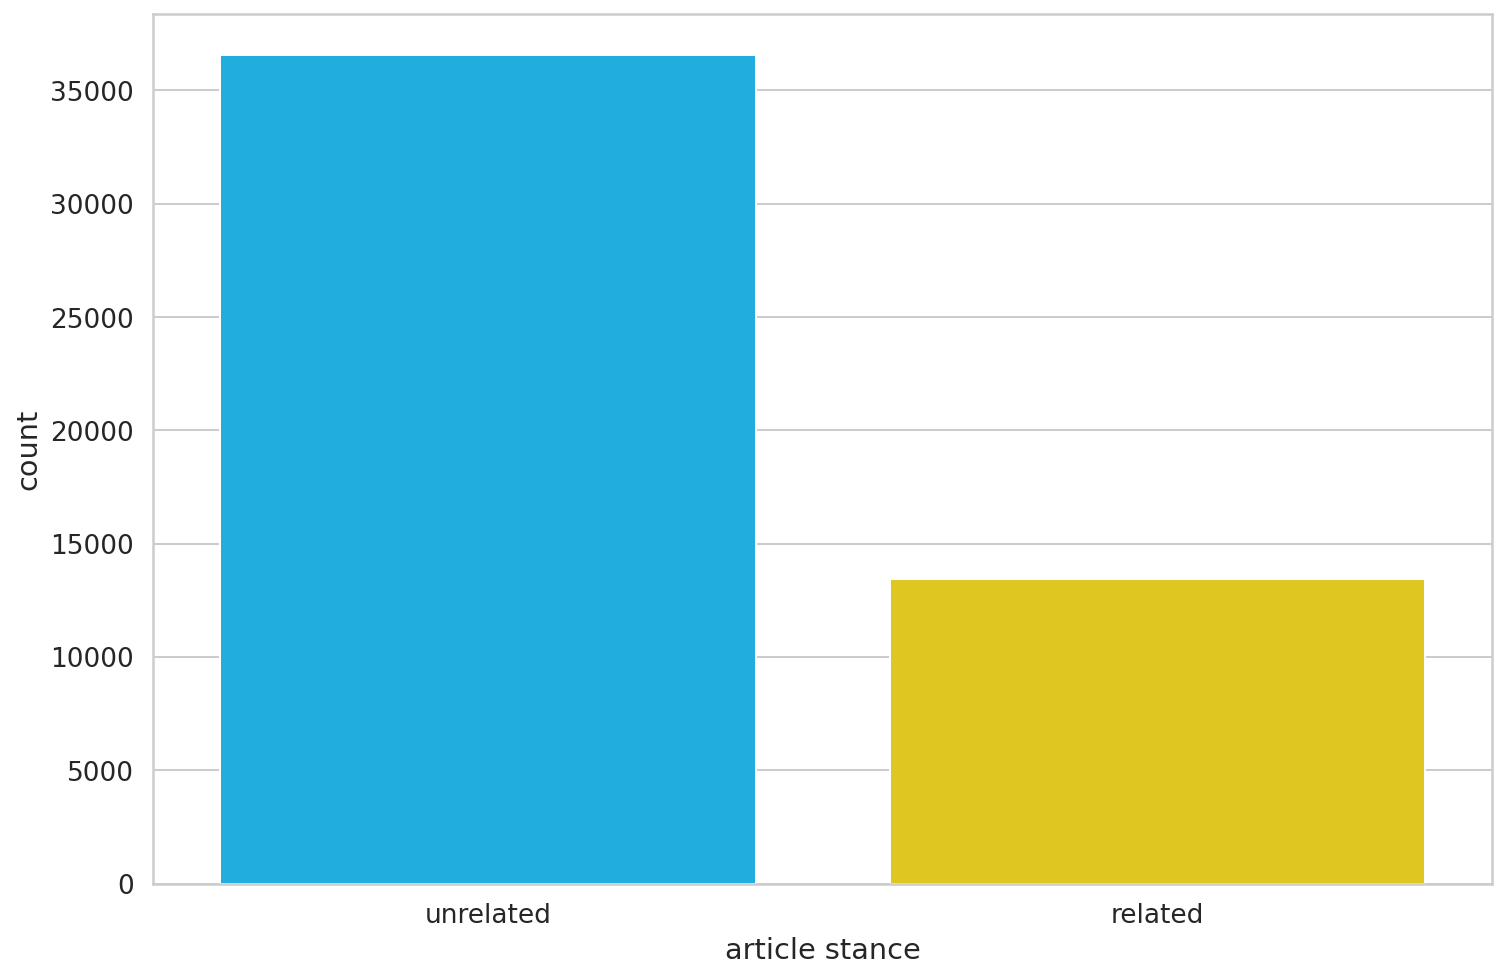

In [ ]:
sns.countplot(df_stances_train_filtered.Stance)
plt.xlabel('article stance')

### 2. Tokenization

In [ ]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# choosing sequence length
token_lens = []

for txt in df_body_train.articleBody:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

# plot distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
max_len = 250

## Model Functions

In [ ]:
class ArticleDataset(Dataset):

  # takes in headlines and bodies from the original corpus
  # just send in the pandas dataframe?
  def __init__(self, headlines, bodies, tokenizer, max_len):
    self.headlines = headlines
    self.bodies = bodies
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.stances = ['unrelated', 'related']
  
  def __len__(self):
    return len(self.headlines)
  
  # return the headline, body article, input_ids, attention masks, and stance
  def __getitem__(self, item):
    sample_headline = self.headlines.iloc[item, 0]
    body_id = self.headlines.iloc[item, 1]
    sample_body = self.bodies.loc[self.bodies["Body ID"] == body_id, "articleBody"].item()
    stance = self.stances.index(self.headlines.iloc[item, 2])

    encoding = self.tokenizer(
      sample_headline,
      sample_body,
      max_length = max_len,
      padding='max_length',
      truncation = True,
      return_tensors = 'pt',
    )

    return {
      'headline': sample_headline,
      'article_body': sample_body,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stance': torch.tensor(stance)
    }

In [ ]:
batch_size = 16

In [ ]:
# helper function to create a data loader
def create_data_loader(df_s, df_b, tokenizer, max_len, batch_size):
  ds = ArticleDataset(
    headlines = df_s,
    bodies = df_b,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
  )

In [ ]:
train_data_loader = create_data_loader(df_stances_train_filtered, df_body_train, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_stances_test_filtered, df_body_test, tokenizer, max_len, batch_size)

In [ ]:
class StanceClassifier(nn.Module):

  def __init__(self, n_classes):
    super(StanceClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    X = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
    )
  
    output = self.drop(X[1])
    return self.out(output)

In [ ]:
model = StanceClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [ ]:
# training
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

weight = torch.tensor([0.684, 1.86])
loss_fn = nn.CrossEntropyLoss(weight=weight).to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# helper function for training model for one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i, d in enumerate(data_loader):
    print(f"Batch: {i}")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stance = d["stance"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stance)

    correct_predictions += torch.sum(preds == stance)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      print(f"Batch: {i}")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stance)

      correct_predictions += torch.sum(preds == stance)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_stances_train_filtered)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  # val_acc, val_loss = eval_model(
  #     model,
  #     val_data_loader,
  #     loss_fn, 
  #     device, 
  #     len(df_stances_val)
  # )

  # print(f'Val   loss {val_loss} accuracy {val_acc}')
  # print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  # history['val_acc'].append(val_acc)
  # history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = train_acc

In [ ]:
# helper function to get predictions - similar to evaluation but storing
# review texts and probabilities
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(stance)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=stances))

              precision    recall  f1-score   support

   unrelated       0.98      0.99      0.98      9231
     related       0.96      0.94      0.95      3475

    accuracy                           0.97     12706
   macro avg       0.97      0.96      0.97     12706
weighted avg       0.97      0.97      0.97     12706



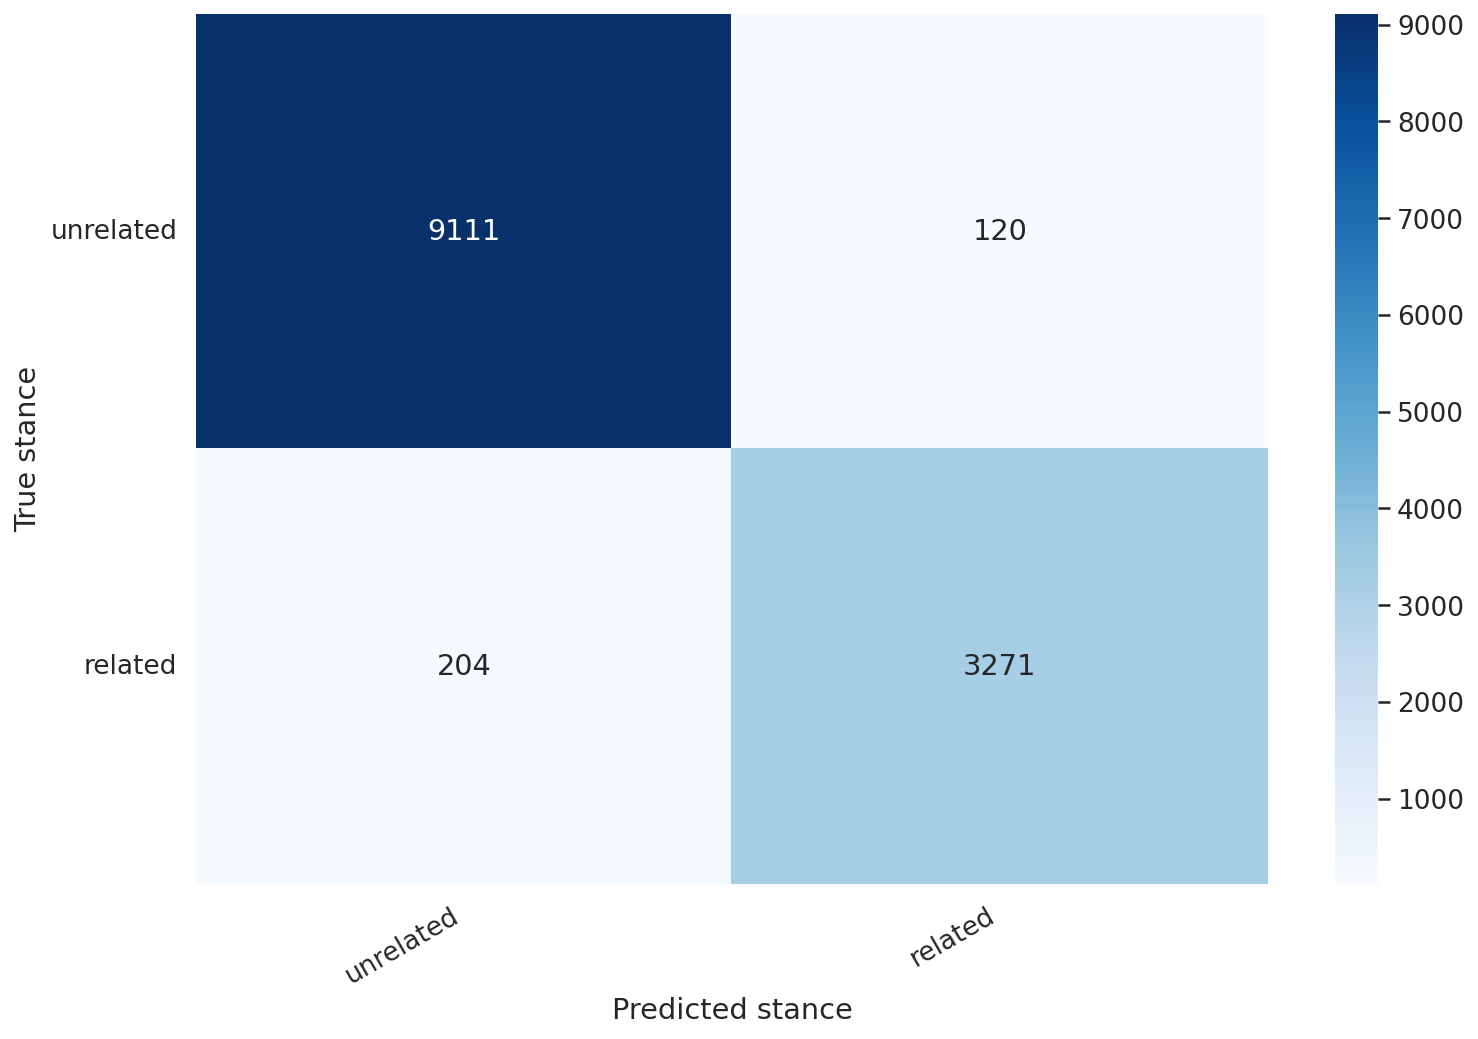

In [ ]:
# confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stances, columns=stances)
show_confusion_matrix(df_cm)